# Time Series KMeans

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
# # -1〜+1の間に規格化
# def normalize(score):
#     norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
#     norm = norm * 2
#     norm = norm - np.mean(norm, axis=0)
#     return norm

In [3]:
# 分類されたクラスタを表示
def show_cluster(tm_kmeans, suptitle, title, n_row=3, n_col=3):
    center = tm_kmeans.cluster_centers_[:,:,0]
    plt.figure(figsize=(15, 10))
    plt.suptitle(suptitle, fontsize=20)
    for i in np.arange(len(center)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.set_title(f'{title}:{i+1}', fontsize=15)
        ax.plot(center[i])
    plt.tight_layout()
    plt.show()

In [4]:
class AozoraTSKmeas:

    def __init__(self, n_clusters, metrics='dtw', random_state=0):
        self.tskmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, random_state=random_state)

    def fit_transform(self, A):
        self.A = A
        self.distances = self.tskmeans.fit_transform(self.A)
    
    # 分類されたクラスタを表示
    def show_cluster(self, suptitle, title, n_row=3, n_col=3):
        center = self.tskmeans.cluster_centers_[:,:,0]
        plt.figure(figsize=(15, 10))
        plt.suptitle(suptitle, fontsize=20)
        for i in np.arange(len(center)):
            ax = plt.subplot(n_row, n_col, i+1)
            ax.set_title(f'{title}:{i+1}', fontsize=15)
            ax.plot(center[i])
        plt.tight_layout()
        plt.show()

    # クラスタとクラスタに近いデータを表示
    """
    Parameters
    ----------
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    label_num: ラベル表示数
    """
    def show_cluster_sumples(self, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'center{cell} ({count})', fontsize=15)
            for idx in distance_dicts_sort_key[:disp_num]:
                ax.plot(self.A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                top_stories.append(f'{novel} ({author})\n{url}')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(self.tskmeans.cluster_centers_[label].ravel(), c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    
    # クラスタに近い小説を表示
    """
    Parameters
    ----------
    kmeans: TimeSeriesKMenasのインスタンス
    distances: 中心からの距離
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    """
    def show_novels(self, aozora_data, disp_num=20):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        print(f'CLUSTER NUM:{n_clusters}')
        print('NO: 作品名 [副題] (作者,文の長さ)\n')
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # クラスタに近い小説を表示
            top_stories = []
            for idx in distance_dicts_sort_key[:disp_num]:
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                subtitle = aozora_data.iloc[idx].loc['副題']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                length = int(aozora_data.iloc[idx].loc['length'])
                if type(subtitle) is float:
                    top_stories.append(f'{novel} ({author},{length})\n{url}')
                else:
                    top_stories.append(f'{novel} [{subtitle}] ({author},{length})\n{url}')
            xlabel = f'Top Stories of center{label+1}:\n'
            for i in range(disp_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            print(xlabel)

In [5]:
# 使うデータは1149冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_1124.csv'
TARGET_PATH = 'data/target2.csv'

In [6]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
print(score_df.shape)
score_df.head()

(1149, 100)


S00       S01       S02       S03       S04       S05       S06  \
13  0.025661  0.000000  0.054238  0.066828  0.170504  0.276141  0.331507   
19  0.582563  0.548885  0.555228  0.577744  0.582888  0.640445  0.639444   
24  0.558150  0.573397  0.559897  0.556415  0.527930  0.403733  0.370236   
30  0.630050  0.571001  0.543094  0.548430  0.484186  0.561365  0.504428   
41  0.911461  1.000000  0.947067  0.883412  0.842882  0.885247  0.841734   

         S07       S08       S09  ...       S90       S91       S92       S93  \
13  0.199721  0.145354  0.078378  ...  0.730720  0.769252  0.744509  0.796472   
19  0.669647  0.633042  0.589699  ...  0.581338  0.537401  0.493915  0.504167   
24  0.465665  0.523025  0.457648  ...  0.028671  0.000000  0.009338  0.099273   
30  0.539505  0.428540  0.503674  ...  0.265228  0.422052  0.512738  0.577317   
41  0.750502  0.746091  0.763377  ...  0.377716  0.371480  0.431062  0.443728   

         S94       S95       S96       S97       S98       S99  
13  0.747293  0.633655  0.644652  0.587357  0.710778  1.000000  
19  0.462203  0.416233  0.410606  0.407270  0.372276  0.337727  
24  0.117307  0.078283  0.066041  0.078662  0.093908  0.292288  
30  0.593348  0.557535  0.642939  0.603872  0.603872  0.551362  
41  0.395934  0.444922  0.424034  0.525714  0.572375  0.650717  

[5 rows x 100 columns]

In [7]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

対象  人物ID      氏名            読み   作品ID    作品名   副題        作品名読み  \
0  True   374   饗庭 篁村      あえば こうそん  45754     良夜  NaN         りょうや   
1  True   879  芥川 竜之介  あくたがわ りゅうのすけ     73  或敵打の話  NaN  あるかたきうちのはなし   

                                            図書カードURL  \
0  https://www.aozora.gr.jp/cards/000374/card4575...   
1  https://www.aozora.gr.jp/cards/000879/card73.html   

                                         テキストファイルURL  \
0  https://www.aozora.gr.jp/cards/000374/files/45...   
1  https://www.aozora.gr.jp/cards/000879/files/73...   

                                          テキストファイルパス  \
0  ./bunko/cards/000374/files/edit/45754_ruby_236...   
1   ./bunko/cards/000879/files/edit/73_ruby_1217.txt   

                                           スコアファイルパス   備考  length  
0  ./bunko/cards/000374/files/score/45754_ruby_23...  NaN   119.0  
1  ./bunko/cards/000879/files/score/73_ruby_1217.txt  NaN   280.0

In [8]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(3)

対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   

                                             図書カードURL  \
13  https://www.aozora.gr.jp/cards/000879/card124....   
19  https://www.aozora.gr.jp/cards/000879/card69.html   
24  https://www.aozora.gr.jp/cards/000879/card77.html   

                                          テキストファイルURL  ...       S90  \
13  https://www.aozora.gr.jp/cards/000879/files/12...  ...  0.730720   
19  https://www.aozora.gr.jp/cards/000879/files/69...  ...  0.581338   
24  https://www.aozora.gr.jp/cards/000879/files/77...  ...  0.028671   

         S91       S92       S93       S94       S95       S96       S97  \
13  0.769252  0.744509  0.796472  0.747293  0.633655  0.644652  0.587357   
19  0.537401  0.493915  0.504167  0.462203  0.416233  0.410606  0.407270   
24  0.000000  0.009338  0.099273  0.117307  0.078283  0.066041  0.078662   

         S98       S99  
13  0.710778  1.000000  
19  0.372276  0.337727  
24  0.093908  0.292288  

[3 rows x 114 columns]

In [9]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

TargetID    対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
0        13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
1        19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
2        24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   
3        30  True   879  芥川 竜之介  あくたがわ りゅうのすけ    38    戯作三昧  NaN   げさくざんまい   
4        41  True   879  芥川 竜之介  あくたがわ りゅうのすけ    59     邪宗門  NaN   じゃしゅうもん   

                                            図書カードURL  ...       S90       S91  \
0  https://www.aozora.gr.jp/cards/000879/card124....  ...  0.730720  0.769252   
1  https://www.aozora.gr.jp/cards/000879/card69.html  ...  0.581338  0.537401   
2  https://www.aozora.gr.jp/cards/000879/card77.html  ...  0.028671  0.000000   
3  https://www.aozora.gr.jp/cards/000879/card38.html  ...  0.265228  0.422052   
4  https://www.aozora.gr.jp/cards/000879/card59.html  ...  0.377716  0.371480   

        S92       S93       S94       S95       S96       S97       S98  \
0  0.744509  0.796472  0.747293  0.633655  0.644652  0.587357  0.710778   
1  0.493915  0.504167  0.462203  0.416233  0.410606  0.407270  0.372276   
2  0.009338  0.099273  0.117307  0.078283  0.066041  0.078662  0.093908   
3  0.512738  0.577317  0.593348  0.557535  0.642939  0.603872  0.603872   
4  0.431062  0.443728  0.395934  0.444922  0.424034  0.525714  0.572375   

        S99  
0  1.000000  
1  0.337727  
2  0.292288  
3  0.551362  
4  0.650717  

[5 rows x 115 columns]

In [10]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

S00       S01       S02       S03       S04       S05       S06  \
0     0.025661  0.000000  0.054238  0.066828  0.170504  0.276141  0.331507   
1     0.582563  0.548885  0.555228  0.577744  0.582888  0.640445  0.639444   
2     0.558150  0.573397  0.559897  0.556415  0.527930  0.403733  0.370236   
3     0.630050  0.571001  0.543094  0.548430  0.484186  0.561365  0.504428   
4     0.911461  1.000000  0.947067  0.883412  0.842882  0.885247  0.841734   
...        ...       ...       ...       ...       ...       ...       ...   
1144  0.371186  0.378760  0.386528  0.339484  0.285766  0.277933  0.382564   
1145  0.437440  0.482706  0.517392  0.551245  0.494324  0.588308  0.834371   
1146  0.470147  0.249427  0.014095  0.000000  0.101267  0.223443  0.426699   
1147  0.739212  0.749024  0.736779  0.643931  0.616012  0.663360  0.682658   
1148  1.000000  0.944829  0.915517  0.867007  0.756865  0.687217  0.648176   

           S07       S08       S09  ...       S90       S91       S92  \
0     0.199721  0.145354  0.078378  ...  0.730720  0.769252  0.744509   
1     0.669647  0.633042  0.589699  ...  0.581338  0.537401  0.493915   
2     0.465665  0.523025  0.457648  ...  0.028671  0.000000  0.009338   
3     0.539505  0.428540  0.503674  ...  0.265228  0.422052  0.512738   
4     0.750502  0.746091  0.763377  ...  0.377716  0.371480  0.431062   
...        ...       ...       ...  ...       ...       ...       ...   
1144  0.275879  0.253945  0.252759  ...  0.138954  0.261761  0.402737   
1145  0.974845  0.893092  0.853586  ...  0.560551  0.609075  0.651563   
1146  0.745355  0.715074  0.778432  ...  0.343102  0.314400  0.368532   
1147  0.645834  0.565077  0.522415  ...  0.287183  0.283420  0.359421   
1148  0.591939  0.527043  0.540444  ...  0.036317  0.062980  0.060436   

           S93       S94       S95       S96       S97       S98       S99  
0     0.796472  0.747293  0.633655  0.644652  0.587357  0.710778  1.000000  
1     0.504167  0.462203  0.416233  0.410606  0.407270  0.372276  0.337727  
2     0.099273  0.117307  0.078283  0.066041  0.078662  0.093908  0.292288  
3     0.577317  0.593348  0.557535  0.642939  0.603872  0.603872  0.551362  
4     0.443728  0.395934  0.444922  0.424034  0.525714  0.572375  0.650717  
...        ...       ...       ...       ...       ...       ...       ...  
1144  0.410529  0.467613  0.512712  0.541754  0.584157  0.623428  0.680844  
1145  0.537071  0.510816  0.438429  0.479817  0.365578  0.265369  0.577571  
1146  0.360149  0.418148  0.424724  0.391853  0.469425  0.543230  0.752012  
1147  0.393291  0.460386  0.445095  0.481291  0.522725  0.597991  0.773582  
1148  0.065140  0.078010  0.110631  0.161243  0.176215  0.210618  0.319444  

[1149 rows x 100 columns]

In [11]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [12]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = scores.copy()
# A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1149, 100), 0.0, 1.0, 0.48169173221309575)

In [13]:
# 軸を追加しておく
A = A[:,:,np.newaxis]
A.shape

(1149, 100, 1)

## metric:euclidean

In [15]:
km1 = TimeSeriesKMeans(n_clusters=9, metric='euclidean', random_state=0)
km1.fit(A)

TimeSeriesKMeans(n_clusters=9, random_state=0)

In [16]:
km1.cluster_centers_.shape

(9, 100, 1)

In [17]:
center1 = km1.cluster_centers_[:,:,0]
center1.shape

(9, 100)

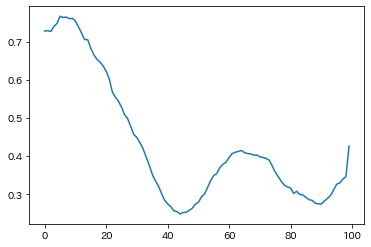

In [18]:
plt.plot(center1[2])

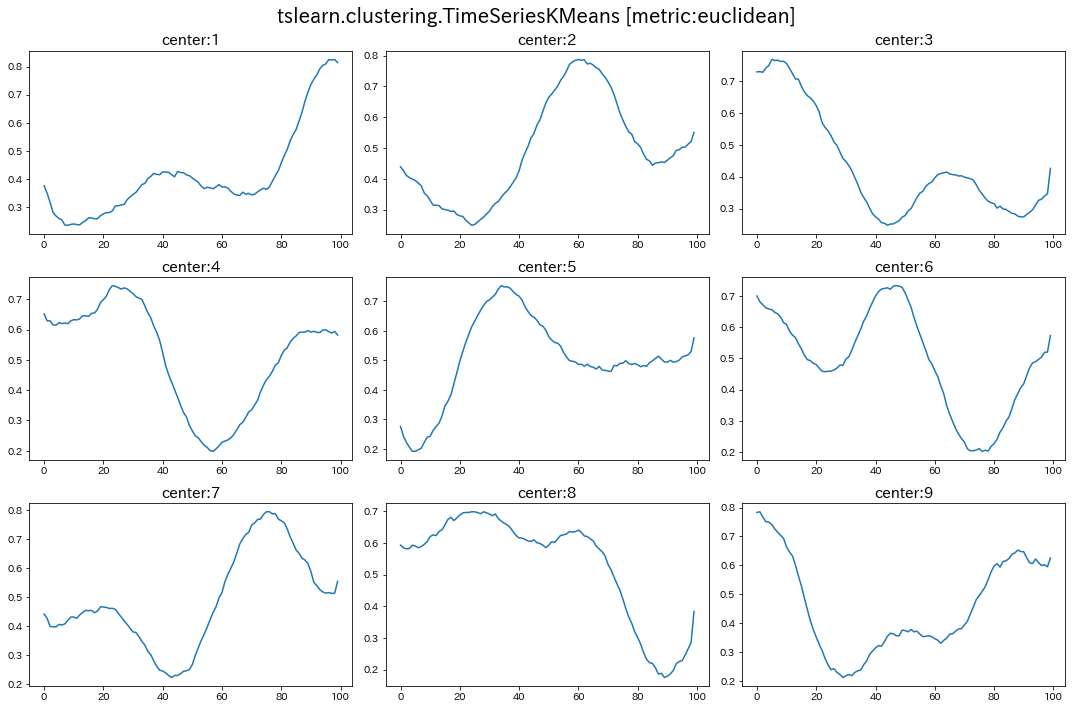

In [19]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:euclidean]'
show_cluster(km1, suptitle, 'center')

## metric:dtw

In [20]:
km2 = TimeSeriesKMeans(n_clusters=9, metric='dtw', random_state=0)
km2.fit(A)

TimeSeriesKMeans(metric='dtw', n_clusters=9, random_state=0)

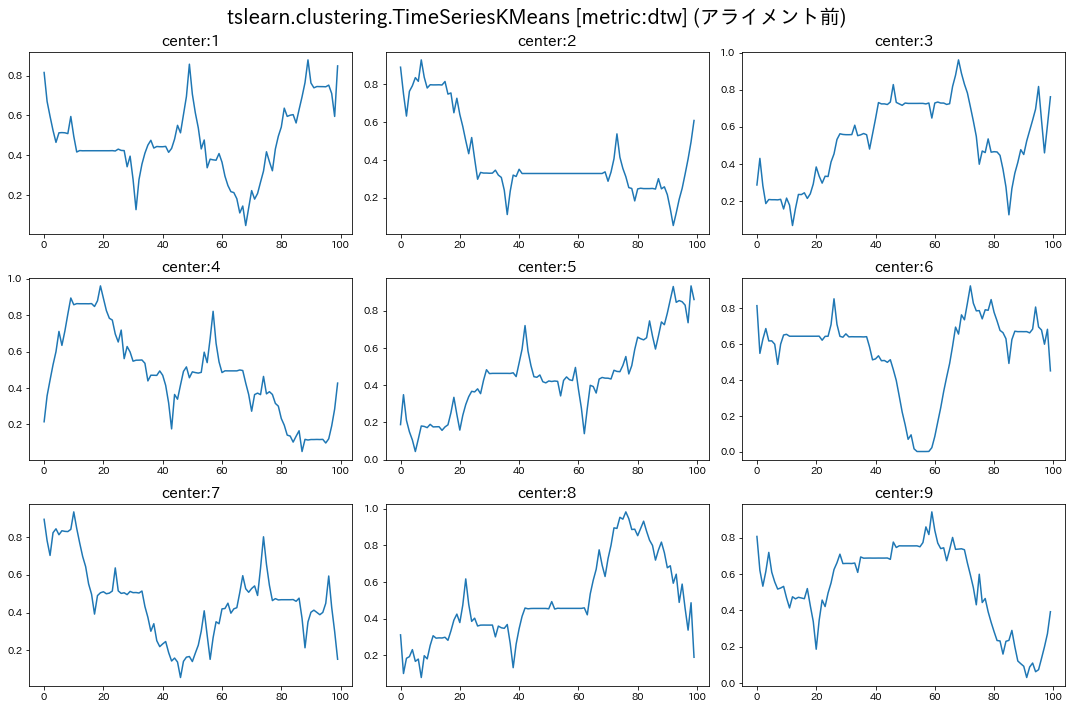

In [21]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)'
show_cluster(km2, suptitle, 'center')

In [22]:
np.unique(km2.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [23]:
km2_pred = km2.predict(A)

In [24]:
distances = km2.transform(A)
distances.shape

(1149, 9)

In [25]:
np.where(km2.labels_==0)[0].shape

(163,)

In [26]:
keys = np.where(km2.labels_==0)[0]
values = distances[km2.labels_==0][:, 0]
distance_dicts = {k: v for k, v in zip(keys, values)}
distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
# np.where(km2.labels_==0)[0], distances[km2.labels_==0][:, 0]

In [27]:
distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
print(distance_dicts_sort_key[:20])

[396, 892, 519, 910, 875, 480, 47, 684, 714, 61, 596, 319, 424, 1085, 552, 222, 174, 586, 248, 1080]


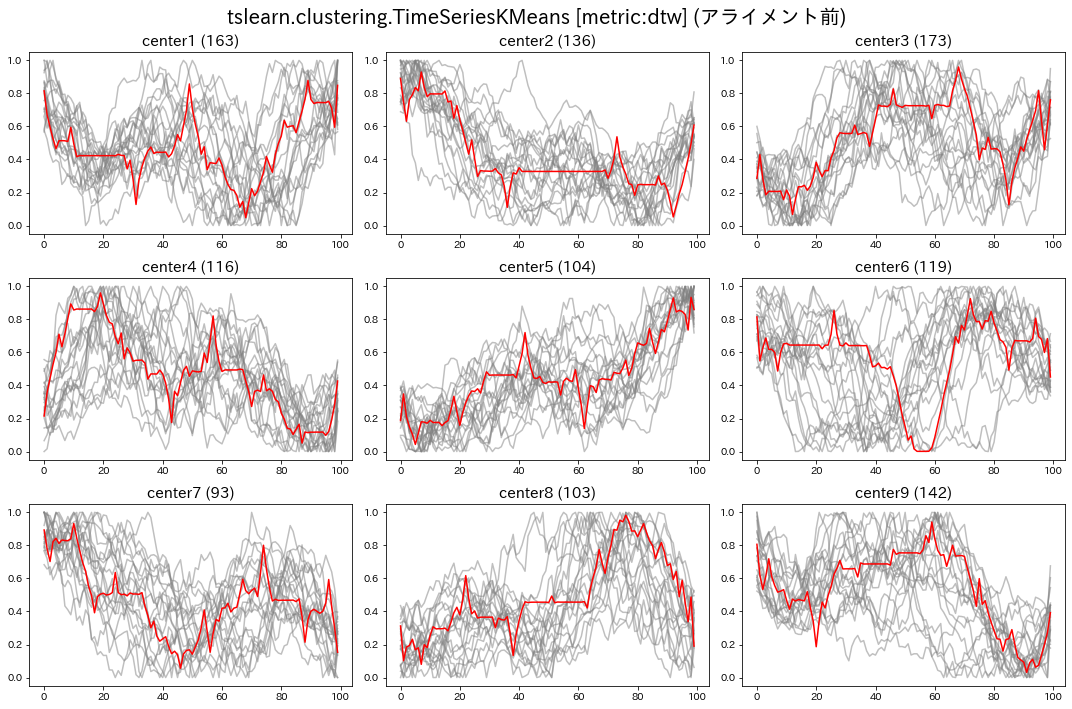

In [28]:
n_clusters = len(np.unique(km2.labels_)) 
disp_num = 20
plt.figure(figsize=(15, 10))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km2.labels_==label)[0]
    values = distances[km2.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(3, 3, cell)
    count = len(distance_dicts_sort_key)
    ax.set_title(f'center{cell} ({count})', fontsize=15)    
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
    plt.plot(km2.cluster_centers_[label].ravel(), c='red')
plt.tight_layout()
plt.show()

## metric:softdtw

In [29]:
# 遅いです．．
km3 = TimeSeriesKMeans(n_clusters=9, metric='softdtw', random_state=0)
km3.fit(A)

TimeSeriesKMeans(metric='softdtw', n_clusters=9, random_state=0)

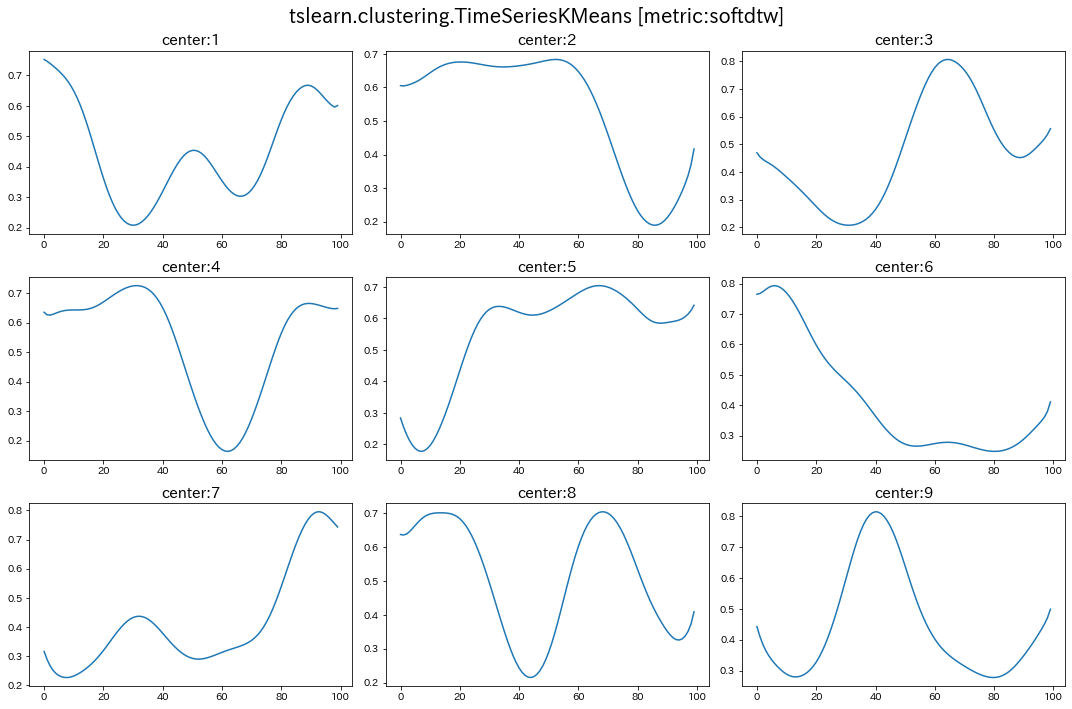

In [30]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:softdtw]'
show_cluster(km3, suptitle, 'center')

## エルボー法

In [31]:
distortions = []
tskms = []
for n in range(1, 11):
    print('n_clusters:', n)
    km = TimeSeriesKMeans(n_clusters=n, metric='dtw', random_state=0)
    km.fit(A)
    tskms.append(km)
    distortions.append(km.inertia_)

n_clusters: 1
n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9
n_clusters: 10


In [32]:
# 作成したモデルを保存しておく
for i in range(len(tskms)):
    # print(i, f'data/tskm_cluster{i+1}.hdf5')
    file_path = f'data/tskm_cluster{i+1}.hdf5'
    if os.path.isfile(file_path):
        os.remove(file_path)
    tskms[i].to_hdf5(file_path)

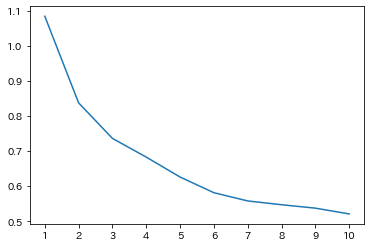

In [33]:
plt.plot(distortions)
plt.xticks(range(10), range(1,11))
plt.show()

## シルエット法

In [34]:
# シルエット法で検証する
silhouette_scores = []
for n in range(1, 10):
    print(f'calc.. silhouette score [cluster{n+1}]')
    ss = silhouette_score(A, tskms[n].labels_, 'dtw')
    silhouette_scores.append(ss)
    print(f'silhouette score [cluster{n+1}]: {ss}')

calc.. silhouette score [cluster2]
silhouette score [cluster2]: 0.2747864866032404
calc.. silhouette score [cluster3]
silhouette score [cluster3]: 0.2022001248802747
calc.. silhouette score [cluster4]
silhouette score [cluster4]: 0.15185398363381744
calc.. silhouette score [cluster5]
silhouette score [cluster5]: 0.15051548822238597
calc.. silhouette score [cluster6]
silhouette score [cluster6]: 0.12490924979836183
calc.. silhouette score [cluster7]
silhouette score [cluster7]: 0.11116718169225258
calc.. silhouette score [cluster8]
silhouette score [cluster8]: 0.11062466096929707
calc.. silhouette score [cluster9]
silhouette score [cluster9]: 0.1011795485273749
calc.. silhouette score [cluster10]
silhouette score [cluster10]: 0.09869035083123054


In [35]:
for i in range(len(silhouette_scores)):
    print(f'silhouette score [cluster{i+2}]: {round(silhouette_scores[i],3)}')

silhouette score [cluster2]: 0.275
silhouette score [cluster3]: 0.202
silhouette score [cluster4]: 0.152
silhouette score [cluster5]: 0.151
silhouette score [cluster6]: 0.125
silhouette score [cluster7]: 0.111
silhouette score [cluster8]: 0.111
silhouette score [cluster9]: 0.101
silhouette score [cluster10]: 0.099


In [36]:
# シルエットスコアを保存しておく
np.save('data/silhouette_scores.npy', np.array(silhouette_scores))

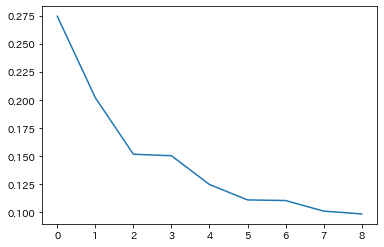

In [37]:
sil_scores = np.load('data/silhouette_scores.npy')
plt.plot(sil_scores)
plt.show()

In [38]:
# 保存されたファイルからロードする場合は以下を実施
tskms = []
for n in range(10):
    file_path = f'data/tskm_cluster{n+1}.hdf5'
    if os.path.isfile(file_path):
        print(f'Load: tskms[{n}]=',file_path, )
        tskms.append(TimeSeriesKMeans.from_hdf5(file_path))
    else:
        print('Skip: ',file_path)

Load: tskms[0]= data/tskm_cluster1.hdf5
Load: tskms[1]= data/tskm_cluster2.hdf5
Load: tskms[2]= data/tskm_cluster3.hdf5
Load: tskms[3]= data/tskm_cluster4.hdf5
Load: tskms[4]= data/tskm_cluster5.hdf5
Load: tskms[5]= data/tskm_cluster6.hdf5
Load: tskms[6]= data/tskm_cluster7.hdf5
Load: tskms[7]= data/tskm_cluster8.hdf5
Load: tskms[8]= data/tskm_cluster9.hdf5
Load: tskms[9]= data/tskm_cluster10.hdf5


In [39]:
silhouette_score(A, tskms[3].labels_, 'dtw')

0.15185398363381744

In [40]:
silhouette_score(A, tskms[5].labels_, 'dtw')

0.12490924979836183

## クラスタ数:4

In [15]:
import pickle
def save_instance(obj, file_path):
    with open(file_path, 'wb') as p:
        pickle.dump(obj, p)

def load_instance(file_path):
    with open(file_path, 'rb') as p:
        return pickle.load(p)

In [66]:
# クラスタ数:4で実施
file_path = 'data/km4.bin'
if os.path.isfile(file_path):
    km4 = load_instance(file_path)
else:
    km4 = AozoraTSKmeas(4)
    km4.fit_transform(A)
    save_instance(km4, file_path)

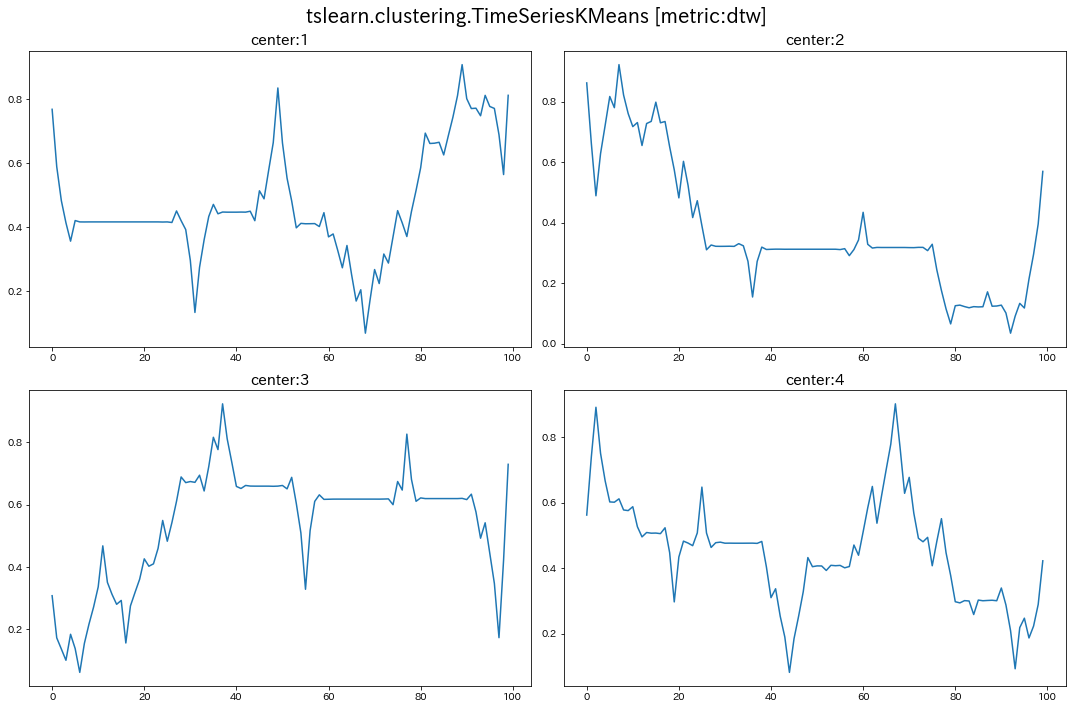

In [67]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km4.show_cluster(suptitle, 'center', 2, 2)

In [68]:
# クラスタ付近の小説を表示
km4.show_novels(df_merge, 5)

CLUSTER NUM:4
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 栄蔵の死 (宮本 百合子,985)
https://www.aozora.gr.jp/cards/000311/card7908.html
02: 南路 (宮本 百合子,812)
https://www.aozora.gr.jp/cards/000311/card2020.html
03: 東京八景 [（苦難の或人に贈る）] (太宰 治,824)
https://www.aozora.gr.jp/cards/000035/card1569.html
04: 二十四の瞳 (壺井 栄,3971)
https://www.aozora.gr.jp/cards/001875/card57856.html
05: 赤ひげ診療譚 [03 むじな長屋] (山本 周五郎,570)
https://www.aozora.gr.jp/cards/001869/card57544.html

Top Stories of center2:
01: 明治開化　安吾捕物 [07 その六　血を見る真珠] (坂口 安吾,819)
https://www.aozora.gr.jp/cards/001095/card43209.html
02: 銭形平次捕物控 [093 百物語] (野村 胡堂,542)
https://www.aozora.gr.jp/cards/001670/card56367.html
03: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html
04: 薤露行 (夏目 漱石,605)
https://www.aozora.gr.jp/cards/000148/card769.html
05: 死の前後 (豊島 与志雄,517)
https://www.aozora.gr.jp/cards/000906/card42455.html

Top Stories of center3:
01: 縁結び (泉 鏡花,576)
https://www.aozora.gr.jp/cards/000050/card3664.html
02: 黒点 [――或る青年の「回想記」

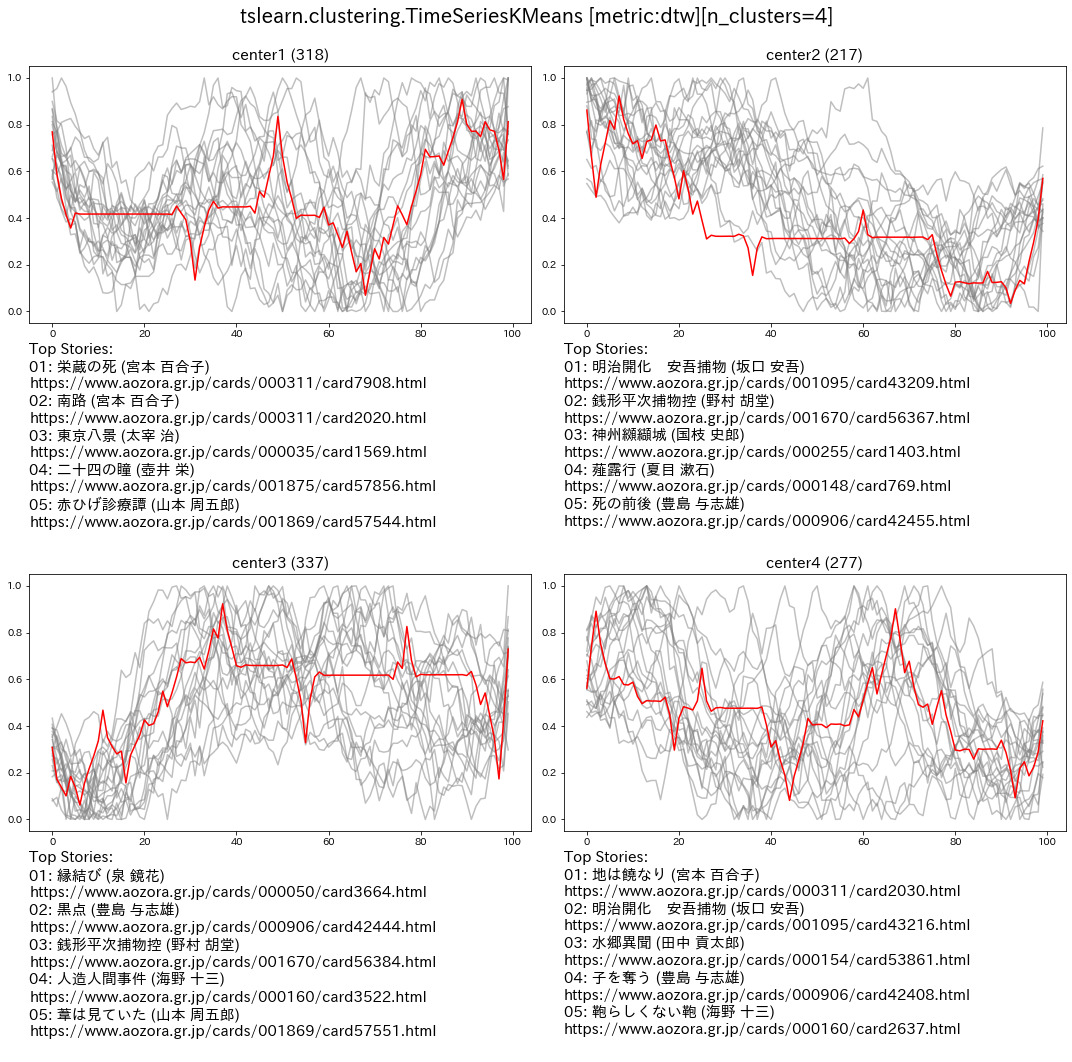

In [69]:
# クラスタとその付近の小説を視覚化
km4.show_cluster_sumples(df_merge, plot_rows=2, plot_cols=2, disp_num=20)

## クラスタ数:5

In [70]:
# クラスタ数:5で実施
file_path = 'data/km5.bin'
if os.path.isfile(file_path):
    km5 = load_instance(file_path)
else:
    km5 = AozoraTSKmeas(5)
    km5.fit_transform(A)
    save_instance(km5, file_path)

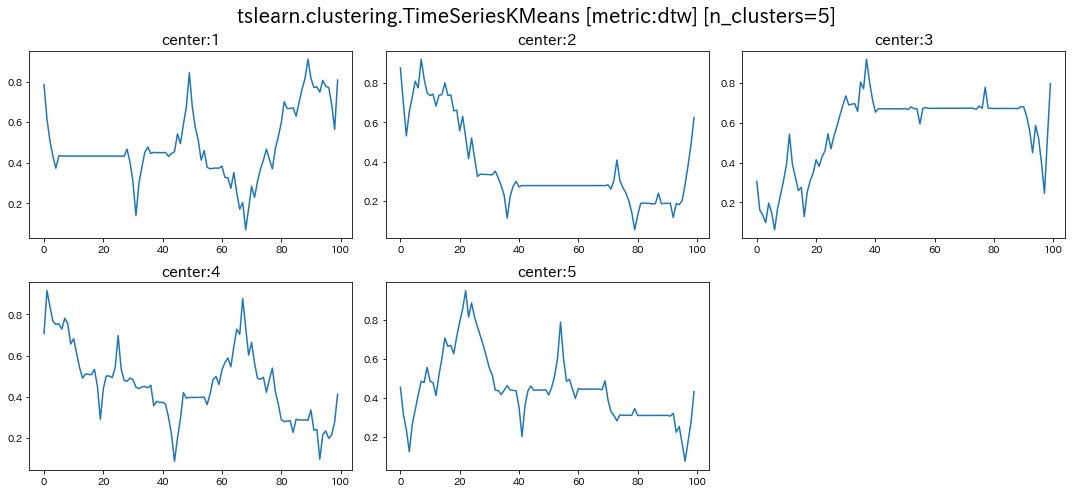

In [71]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=5]'
km5.show_cluster(suptitle, 'center')

In [72]:
# クラスタ付近の小説を表示
km5.show_novels(df_merge, 5)

CLUSTER NUM:5
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 栄蔵の死 (宮本 百合子,985)
https://www.aozora.gr.jp/cards/000311/card7908.html
02: 東京八景 [（苦難の或人に贈る）] (太宰 治,824)
https://www.aozora.gr.jp/cards/000035/card1569.html
03: 人生正会員 (佐々木 邦,613)
https://www.aozora.gr.jp/cards/001750/card55820.html
04: 南路 (宮本 百合子,812)
https://www.aozora.gr.jp/cards/000311/card2020.html
05: 明治開化　安吾捕物 [12 その十一　稲妻は見たり] (坂口 安吾,757)
https://www.aozora.gr.jp/cards/001095/card43214.html

Top Stories of center2:
01: 薤露行 (夏目 漱石,605)
https://www.aozora.gr.jp/cards/000148/card769.html
02: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html
03: 艶書 (山本 周五郎,645)
https://www.aozora.gr.jp/cards/001869/card57598.html
04: 明治開化　安吾捕物 [07 その六　血を見る真珠] (坂口 安吾,819)
https://www.aozora.gr.jp/cards/001095/card43209.html
05: 猫の蚤とり武士 (国枝 史郎,6416)
https://www.aozora.gr.jp/cards/000255/card49836.html

Top Stories of center3:
01: 旗本退屈男 [11 第十一話　千代田城へ乗り込んだ退屈男] (佐々木 味津三,1545)
https://www.aozora.gr.jp/cards/000111/card147

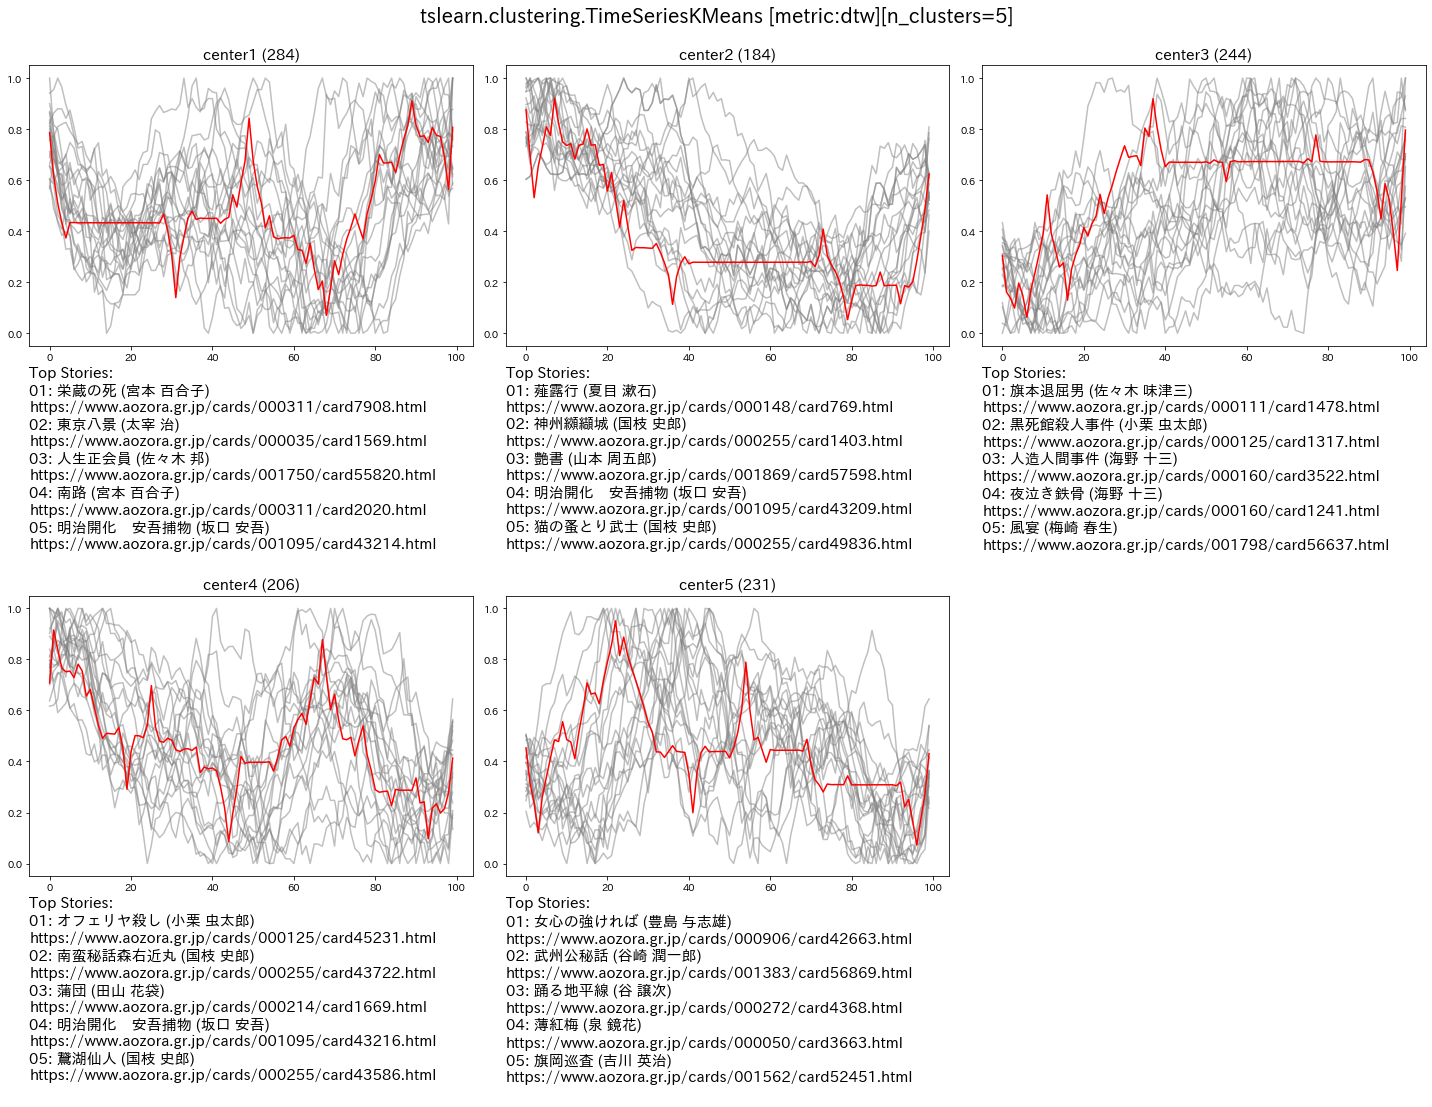

In [73]:
# クラスタとその付近の小説を視覚化
km5.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:6

In [16]:
# クラスタ数:6で実施
file_path = 'data/km6.bin'
if os.path.isfile(file_path):
    km6 = load_instance(file_path)
else:
    km6 = AozoraTSKmeas(6)
    km6.fit_transform(A)
    save_instance(km6, file_path)
# km6 = AozoraTSKmeas(6)
# km6.fit_transform(A)
# save_instance(km6, file_path)

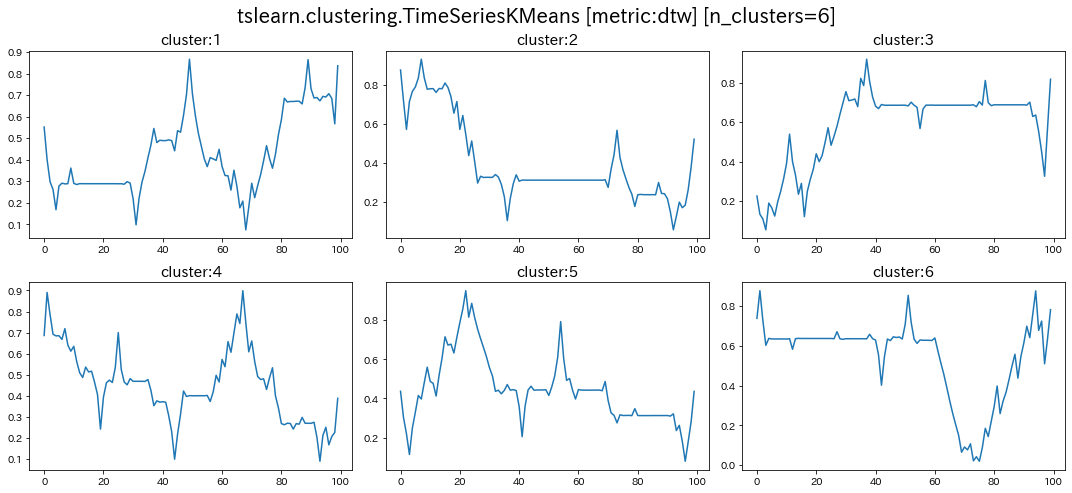

In [21]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=6]'
km6.show_cluster(suptitle, 'cluster')

In [19]:
# クラスタ付近の小説を表示
km6.show_novels(df_merge, 5)

CLUSTER NUM:6
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 円太郎馬車 (正岡 容,725)
https://www.aozora.gr.jp/cards/001313/card47746.html
02: 好意 (豊島 与志雄,542)
https://www.aozora.gr.jp/cards/000906/card42430.html
03: 生々流転 (岡本 かの子,6990)
https://www.aozora.gr.jp/cards/000076/card45641.html
04: 深見夫人の死 (岡本 綺堂,751)
https://www.aozora.gr.jp/cards/000082/card45491.html
05: みさごの鮨 (泉 鏡花,716)
https://www.aozora.gr.jp/cards/000050/card3544.html

Top Stories of center2:
01: 死の前後 (豊島 与志雄,517)
https://www.aozora.gr.jp/cards/000906/card42455.html
02: 半七捕物帳 [46 十五夜御用心] (岡本 綺堂,610)
https://www.aozora.gr.jp/cards/000082/card958.html
03: 薤露行 (夏目 漱石,605)
https://www.aozora.gr.jp/cards/000148/card769.html
04: 大根の葉 (壺井 栄,887)
https://www.aozora.gr.jp/cards/001875/card58601.html
05: 半七捕物帳 [49 大阪屋花鳥] (岡本 綺堂,732)
https://www.aozora.gr.jp/cards/000082/card1013.html

Top Stories of center3:
01: 旗本退屈男 [11 第十一話　千代田城へ乗り込んだ退屈男] (佐々木 味津三,1545)
https://www.aozora.gr.jp/cards/000111/card1478.html
02: 人造人間事件 (海野 十三,548)
htt

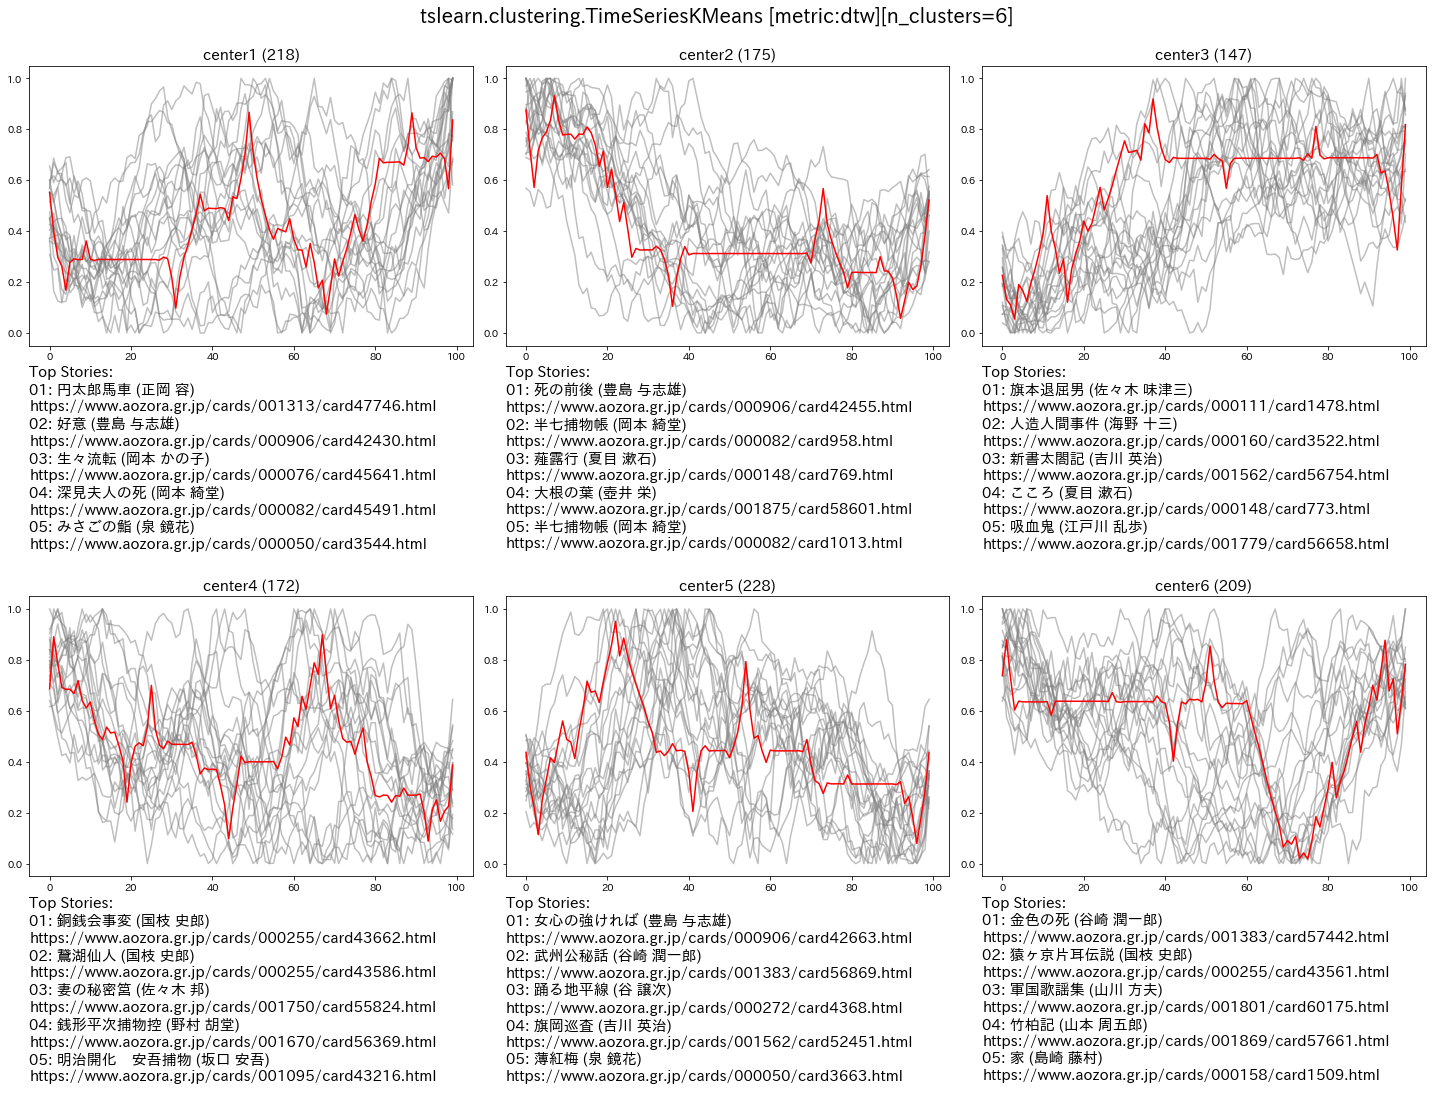

In [20]:
# クラスタとその付近の小説を視覚化
km6.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:7

In [78]:
# クラスタ数:7で実施
file_path = 'data/km7.bin'
if os.path.isfile(file_path):
    km7 = load_instance(file_path)
else:
    km7 = AozoraTSKmeas(7)
    km7.fit_transform(A)
    save_instance(km7, file_path)

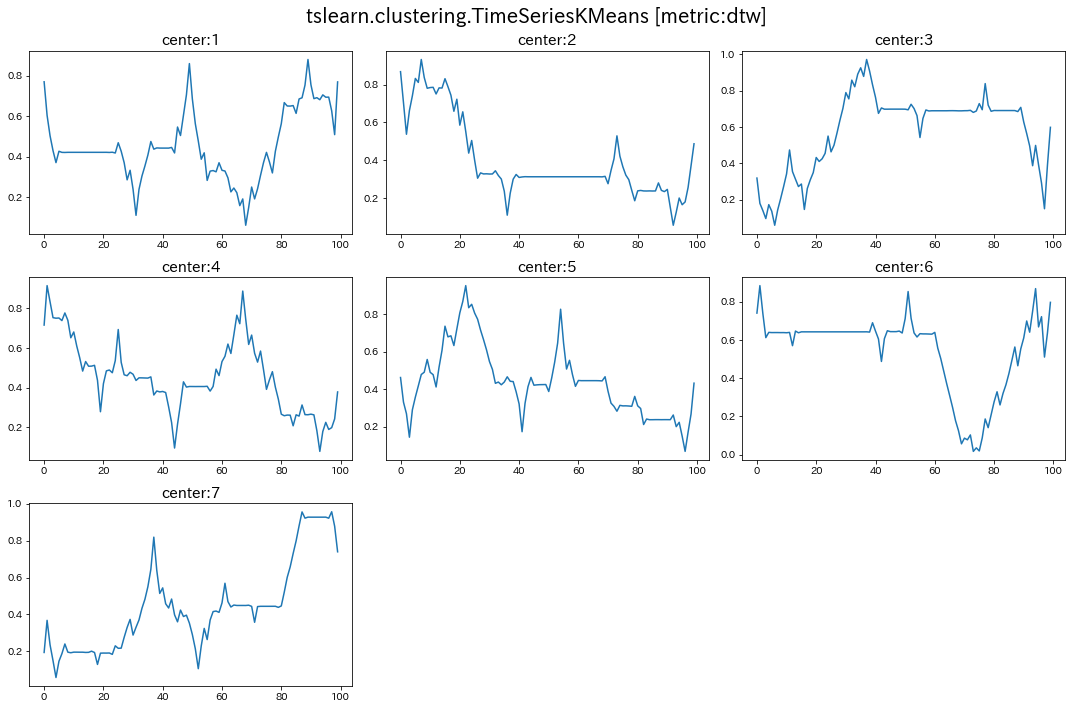

In [79]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km7.show_cluster(suptitle, 'center')

In [80]:
# クラスタ付近の小説を表示
km7.show_novels(df_merge, 5)

CLUSTER NUM:7
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 桜の実の熟する時 (島崎 藤村,3087)
https://www.aozora.gr.jp/cards/000158/card50306.html
02: 明治開化　安吾捕物 [12 その十一　稲妻は見たり] (坂口 安吾,757)
https://www.aozora.gr.jp/cards/001095/card43214.html
03: 人生正会員 (佐々木 邦,613)
https://www.aozora.gr.jp/cards/001750/card55820.html
04: 栄蔵の死 (宮本 百合子,985)
https://www.aozora.gr.jp/cards/000311/card7908.html
05: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html

Top Stories of center2:
01: 死の前後 (豊島 与志雄,517)
https://www.aozora.gr.jp/cards/000906/card42455.html
02: 薤露行 (夏目 漱石,605)
https://www.aozora.gr.jp/cards/000148/card769.html
03: 半七捕物帳 [46 十五夜御用心] (岡本 綺堂,610)
https://www.aozora.gr.jp/cards/000082/card958.html
04: 大根の葉 (壺井 栄,887)
https://www.aozora.gr.jp/cards/001875/card58601.html
05: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html

Top Stories of center3:
01: 青銅の基督 [――一名南蛮鋳物師の死――] (長与 善郎,2236)
https://www.aozora.gr.jp/cards/001521/card51826.html
02: 大捕物

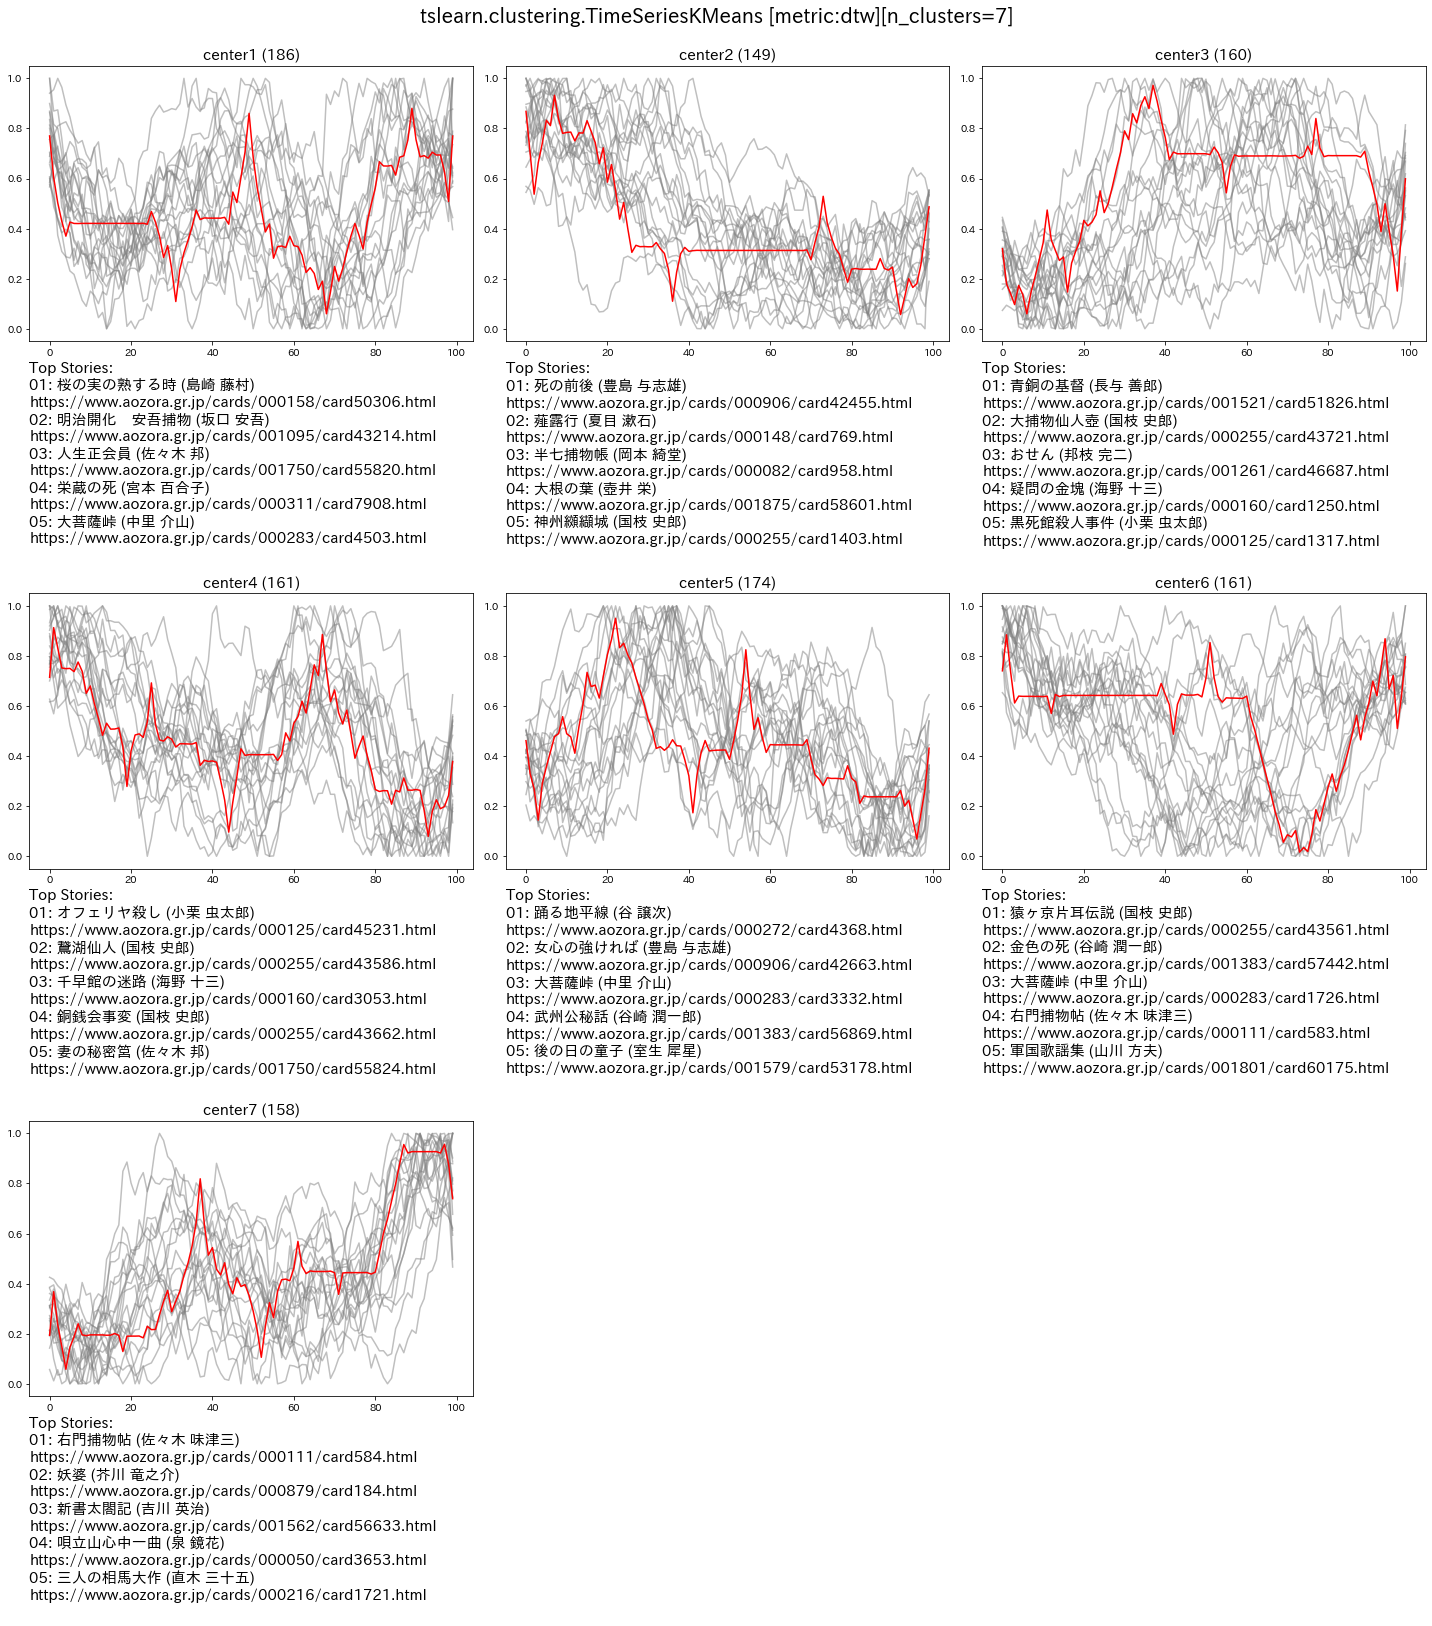

In [81]:
# クラスタとその付近の小説を視覚化
km7.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:8

In [82]:
# クラスタ数:8で実施
file_path = 'data/km8.bin'
if os.path.isfile(file_path):
    km8 = load_instance(file_path)
else:
    km8 = AozoraTSKmeas(8)
    km8.fit_transform(A)
    save_instance(km8, file_path)

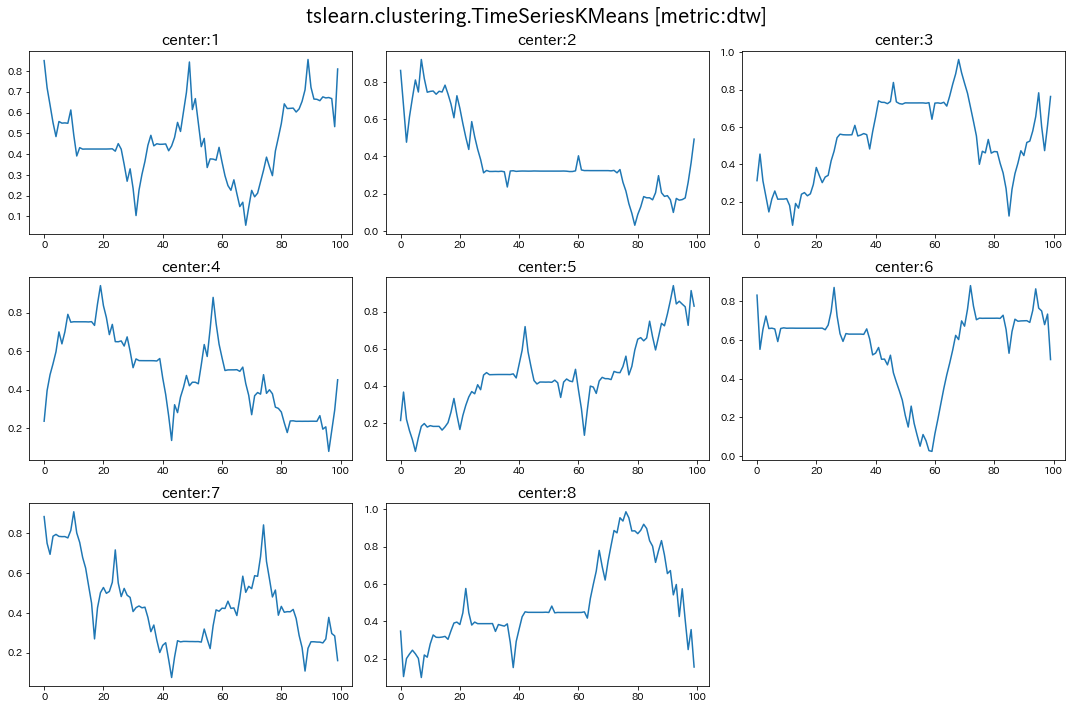

In [83]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km8.show_cluster(suptitle, 'center')

In [84]:
# クラスタ付近の小説を表示
km8.show_novels(df_merge, 5)

CLUSTER NUM:8
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 明治開化　安吾捕物 [12 その十一　稲妻は見たり] (坂口 安吾,757)
https://www.aozora.gr.jp/cards/001095/card43214.html
02: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html
03: 踊る地平線 [08　しっぷ・あほうい！] (谷 譲次,676)
https://www.aozora.gr.jp/cards/000272/card4372.html
04: 家 [01 （上）] (島崎 藤村,3930)
https://www.aozora.gr.jp/cards/000158/card1509.html
05: 栄蔵の死 (宮本 百合子,985)
https://www.aozora.gr.jp/cards/000311/card7908.html

Top Stories of center2:
01: 銭形平次捕物控 [093 百物語] (野村 胡堂,542)
https://www.aozora.gr.jp/cards/001670/card56367.html
02: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html
03: 新書太閤記 [10 第十分冊] (吉川 英治,6127)
https://www.aozora.gr.jp/cards/001562/card56761.html
04: 闘争 (小酒井 不木,522)
https://www.aozora.gr.jp/cards/000262/card1459.html
05: 挿話 (徳田 秋声,737)
https://www.aozora.gr.jp/cards/000023/card50188.html

Top Stories of center3:
01: 大菩薩峠 [20 禹門三級の巻] (中里 介山,1753)
https://www.aozora.gr.jp/cards/000283/

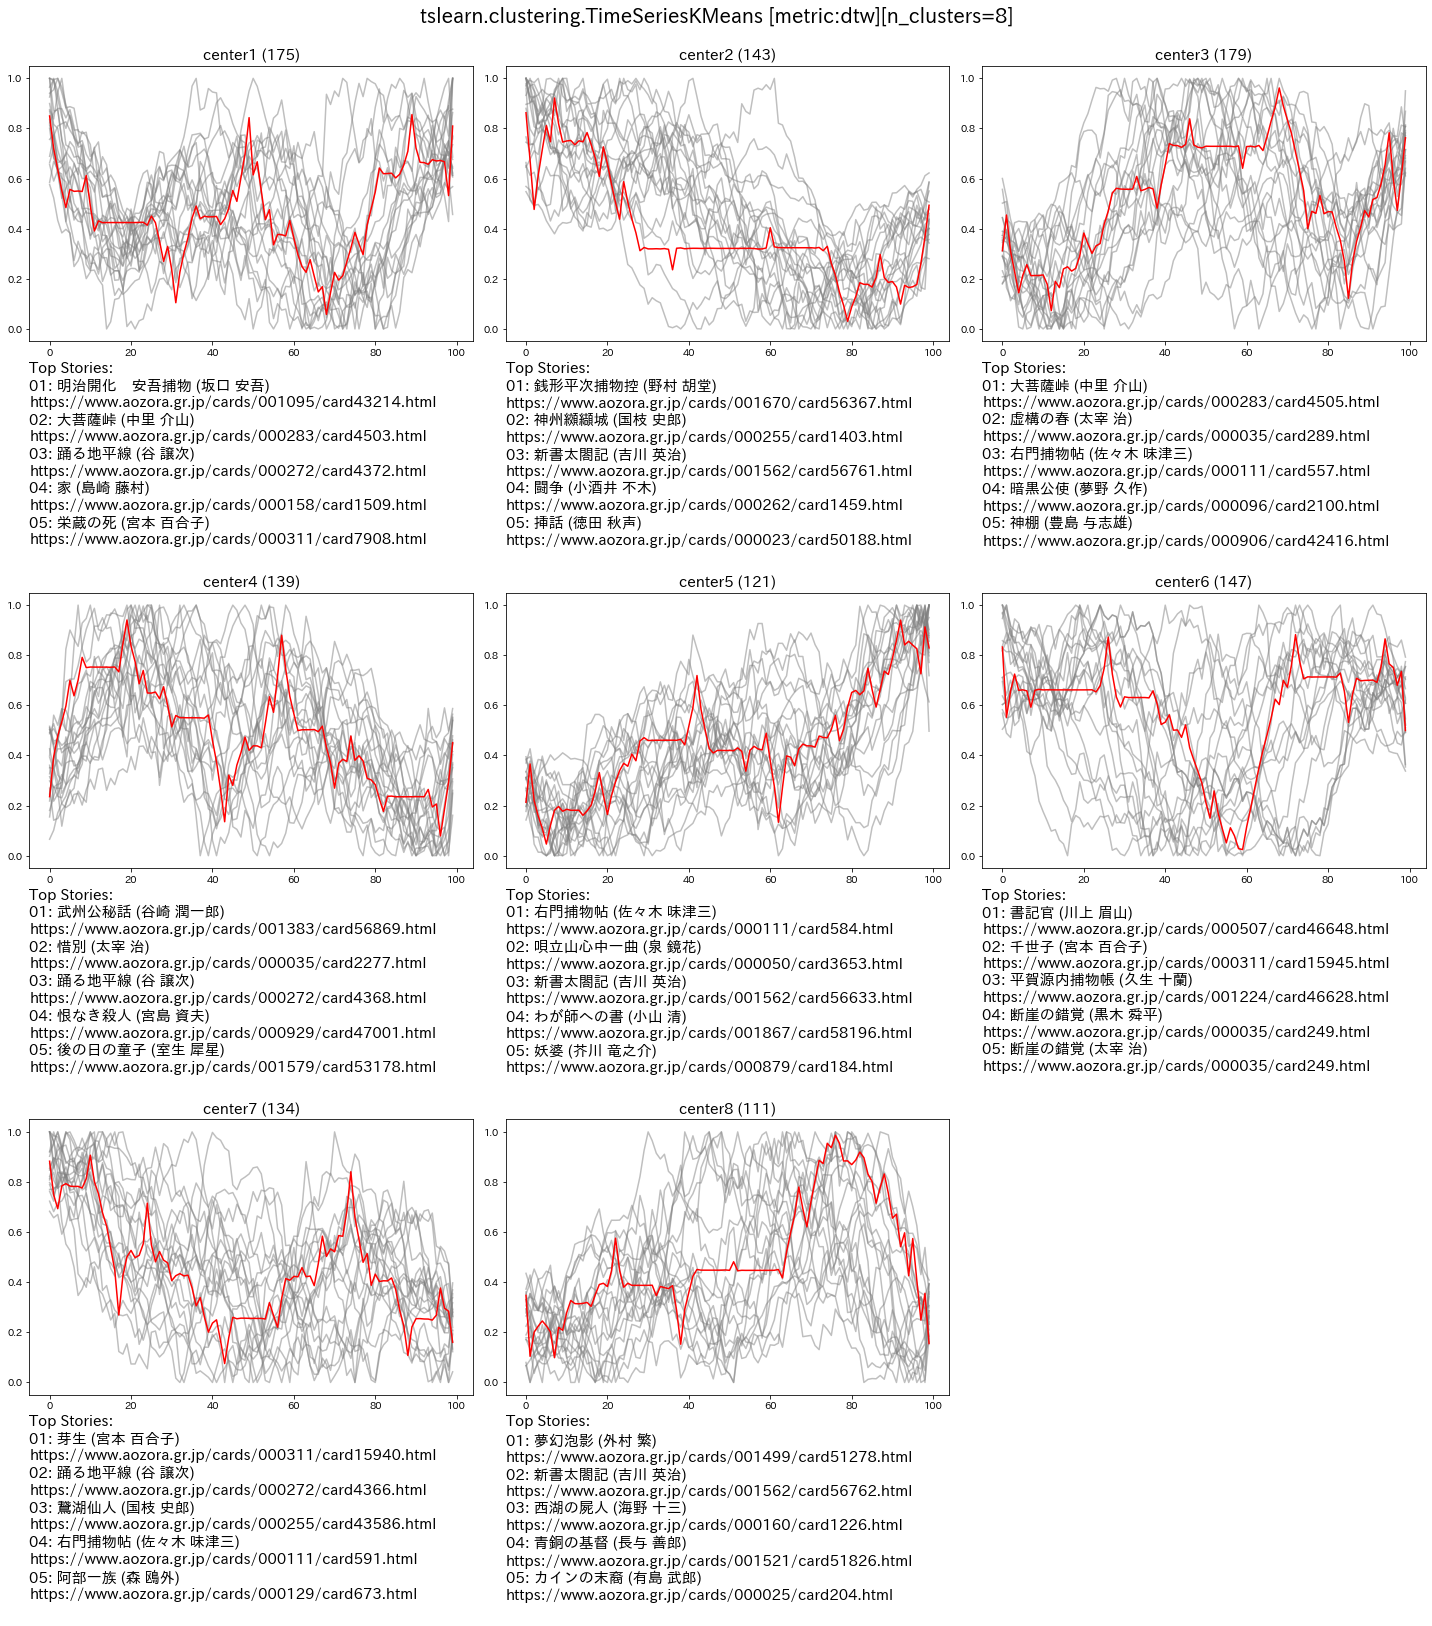

In [85]:
# クラスタとその付近の小説を視覚化
km8.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:9

In [22]:
# クラスタ数:9で実施
file_path = 'data/km9.bin'
# if os.path.isfile(file_path):
#     km9 = load_instance(file_path)
# else:
#     km9 = AozoraTSKmeas(9)
#     km9.fit_transform(A)
#     save_instance(km9, file_path)

km9 = AozoraTSKmeas(9)
km9.fit_transform(A)
save_instance(km9, file_path)

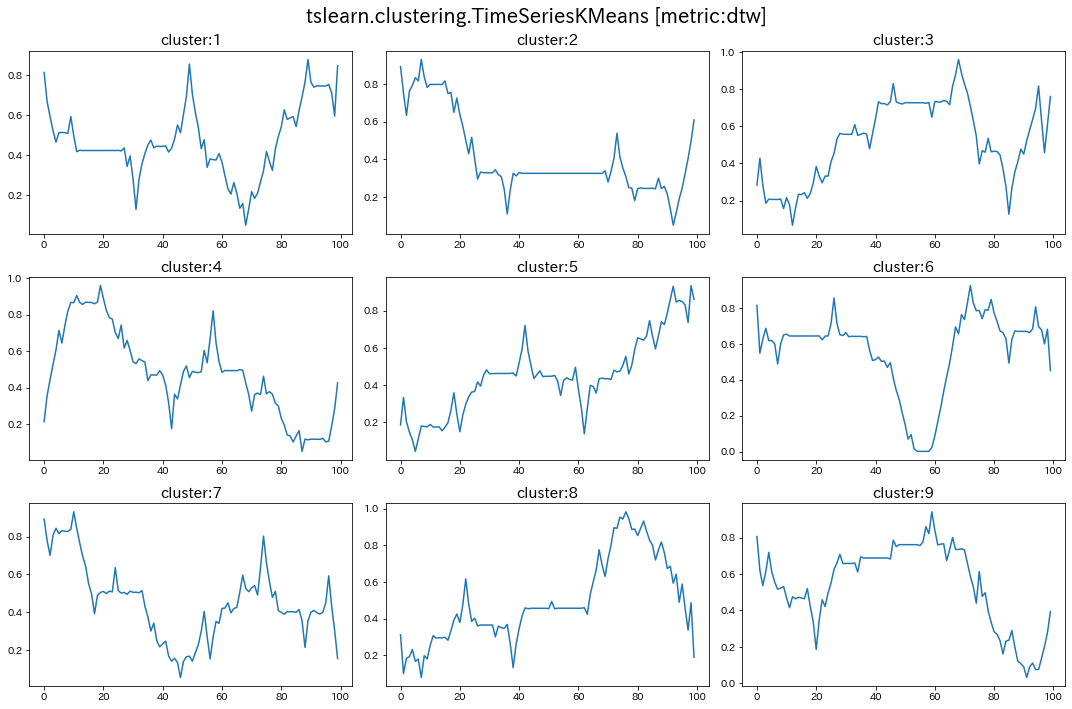

In [23]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km9.show_cluster(suptitle, 'cluster')

In [88]:
# クラスタ付近の小説を表示
km9.show_novels(df_merge, 5)

CLUSTER NUM:9
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 明治開化　安吾捕物 [12 その十一　稲妻は見たり] (坂口 安吾,757)
https://www.aozora.gr.jp/cards/001095/card43214.html
02: 栄蔵の死 (宮本 百合子,985)
https://www.aozora.gr.jp/cards/000311/card7908.html
03: 東京八景 [（苦難の或人に贈る）] (太宰 治,824)
https://www.aozora.gr.jp/cards/000035/card1569.html
04: 南路 (宮本 百合子,812)
https://www.aozora.gr.jp/cards/000311/card2020.html
05: 円太郎馬車 (正岡 容,725)
https://www.aozora.gr.jp/cards/001313/card47746.html

Top Stories of center2:
01: 半七捕物帳 [46 十五夜御用心] (岡本 綺堂,610)
https://www.aozora.gr.jp/cards/000082/card958.html
02: 半七捕物帳 [64 廻り灯籠] (岡本 綺堂,626)
https://www.aozora.gr.jp/cards/000082/card994.html
03: 断層顔 (海野 十三,612)
https://www.aozora.gr.jp/cards/000160/card2616.html
04: 薤露行 (夏目 漱石,605)
https://www.aozora.gr.jp/cards/000148/card769.html
05: 死の前後 (豊島 与志雄,517)
https://www.aozora.gr.jp/cards/000906/card42455.html

Top Stories of center3:
01: 大菩薩峠 [20 禹門三級の巻] (中里 介山,1753)
https://www.aozora.gr.jp/cards/000283/card4505.html
02: 暗黒公使 (夢野 久作

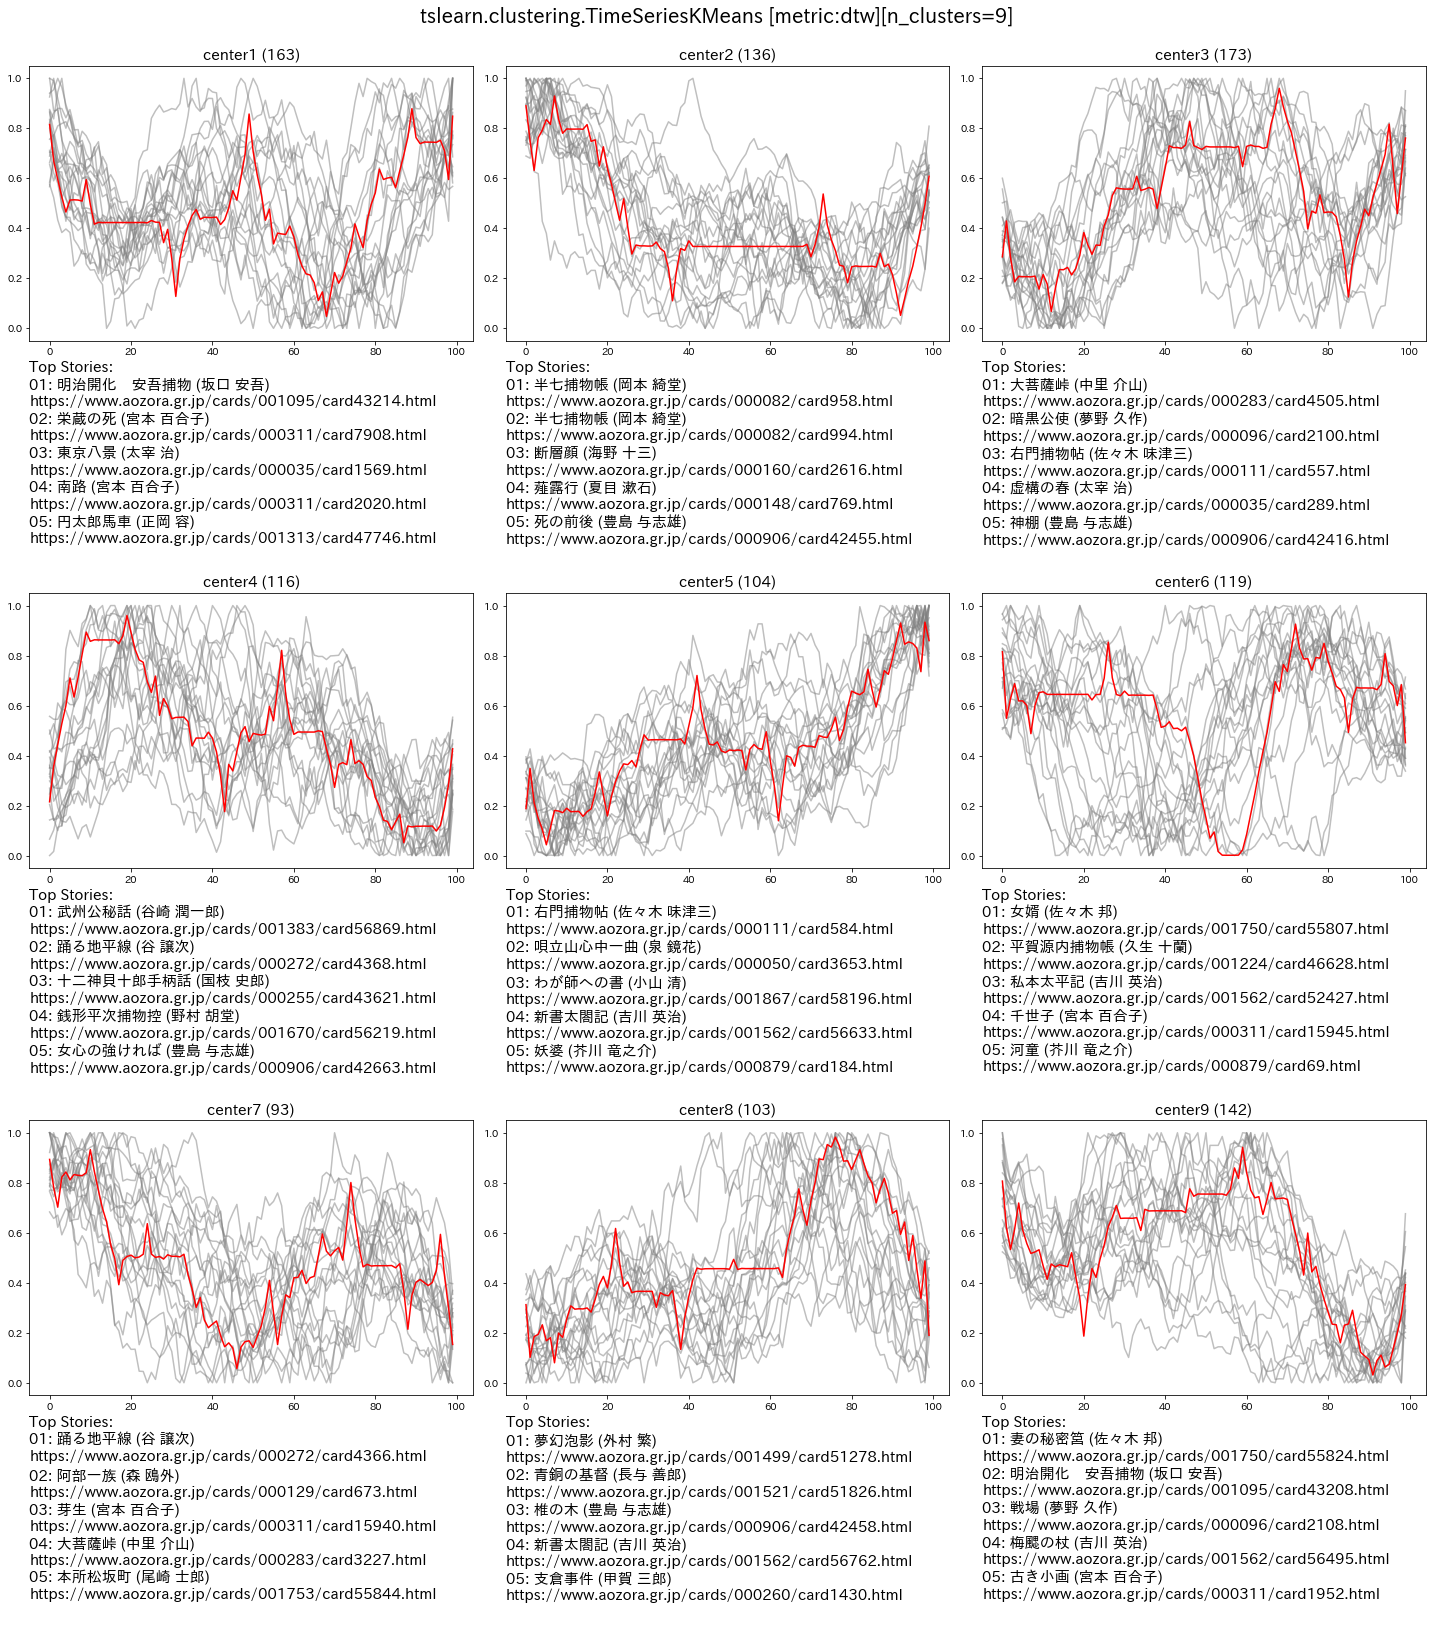

In [89]:
# クラスタとその付近の小説を視覚化
km9.show_cluster_sumples(df_merge, figsize=(20, 23), plot_cols=3)